# Language Model trained with MLP

- Context window is 3 tokens wide.
- Much superior to Bigram.
- This implementation will be a character language model, i.e., given a sequence of characters, it will predict the next character in the sequence.

In [285]:
import torch
import math
import random
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [286]:
device = torch.device('cpu')

### Load 'names.txt' Dataset

In [287]:
names = open('names.txt', 'r').read().splitlines()
print(f"Total Names: {len(names)}", *names[:5], "...", sep=", ")

Total Names: 32033, emma, olivia, ava, isabella, sophia, ...


### Dictionaries to convert characters to int and back

In [288]:
ctoi = {c:i for i, c in enumerate(['.'] + sorted(list(set(''.join(names)))))}
itoc = {i:c for c, i in ctoi.items()}

### Define Block Size

It is the size of the context window. Here, 3 characters are used as it provides a good balance, according to the dataset.

In [289]:
block_size = 3

Using a rolling window to create dataset. `.` character is used as the delimiter.

In [290]:
def build_dataset(words, block_size=block_size):
    X = []
    Y = []
    for word in words:
        context = [0] * block_size
        for c in word + '.':
            ci = ctoi[c]
            X.append(context)
            Y.append(ci)
            # print(''.join(itoc[c] for c in context) + ' ---> ' + itoc[ci])
            context = context[1:] + [ci]

    X = torch.tensor(X, device=device)
    Y = torch.tensor(Y, device=device)
    return X, Y


In [291]:
X, Y = build_dataset(names, block_size=block_size)

In [292]:
X.shape, Y.shape

(torch.Size([228146, 3]), torch.Size([228146]))

### Splitting Data into Training, Validation and Testing

- Training data proportion: 80%     [`Xtrn, Ytrn`]
- Validation data proportion: 10%   [`Xdev, Ydev`]
- Testing data proportion: 10%      [`Xtst, Ytst`]

Data is shuffled to get more accurate results when testing on Xdev / Xtst

In [293]:
trnProp = 0.8
valProp = 0.1

n1 = int(trnProp*len(names))
n2 = int((trnProp + valProp)*len(names))

random.shuffle(names)

Xtrn, Ytrn = build_dataset(names[:n1])
Xdev, Ydev = build_dataset(names[n1:n2])
Xtst, Ytst = build_dataset(names[n2:])

In [294]:
Ytrn.shape, Ydev.shape, Ytst.shape

(torch.Size([182501]), torch.Size([22857]), torch.Size([22788]))

### Define Hyper parameters
- `dims`: number of dimensions used for encoding each token
- `hidden_layer`: number of neurons in the hidden layer of the network

In [295]:
dims = 15
hidden_layer = 150

### Define Model parameters

- `C` : Defines the point in the n-dimensional space for each character
  - Size: `vocab_size` x `dims`
- `W1` : Weights for the first layer
  - Size: `(dims * block_size)` x `hidden_layer`
- `b1` : Bias for the first layer
  - Size: `hidden_layer` x `1`
- `W2` : Weights for the second layer
  - Size: `hidden_layer` x `vocab_size`
- `b2` : Bias for the second layer
  - Size: `vocab_size` x `1`

In [296]:
g = torch.Generator(device=device).manual_seed(0)
C = torch.randn((27, dims),                         generator=g, device=device)

W1 = torch.randn((dims*block_size, hidden_layer),   generator=g, device=device) * 0.14
b1 = torch.randn(hidden_layer,                      generator=g, device=device) * 0.01

W2 = torch.randn((hidden_layer, 27),                generator=g, device=device) * 0.01
b2 = torch.randn(27,                                generator=g, device=device) * 0

parameters = [C, W1, b1, W2, b2]
print(f"Total Parameter: {sum(p.nelement() for p in parameters)}")

Total Parameter: 11382


In [297]:
for p in parameters:
    p.requires_grad = True

In [298]:
losstrn = [] # For tracking loss during training

Function to calculate loss on given dataset

In [299]:
@torch.no_grad
def getloss(X, Y):
    emb = C[X]
    h = torch.tanh(emb.view((-1, block_size*dims)) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y)
    return loss

### Training
- `nitr` : Number of iterations - Set to 600K
- `lrs` : Array of learning rates - linear decay from 0.1 to 0.005
- Batch size for training: 64

In [309]:
nitr = 200000
lrs = torch.linspace(0.1, 0.001, nitr)
for g in range(nitr):
    # batching
    ix = torch.randint(0, Xtrn.shape[0], (64,))
    # forward pass
    emb = C[Xtrn[ix]]
    h = torch.tanh(emb.view((-1, block_size*dims)) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Ytrn[ix])
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    lr = lrs[g]
    for p in parameters:
        p.data += -lr * p.grad
    # track stats
    losstrn.append(loss)
    # break

In [301]:
logits[0]

tensor([ 0.1928,  0.0733,  0.0461, -0.0350, -0.0440,  0.0172, -0.1167,  0.0031,
        -0.1025,  0.0467,  0.0240,  0.0299, -0.0039,  0.1445,  0.0146, -0.0558,
         0.0027,  0.0047, -0.0894, -0.1381, -0.0532,  0.0229,  0.0255,  0.0056,
        -0.0328,  0.0074, -0.0653], grad_fn=<SelectBackward0>)

### Plot of log loss vs iterations

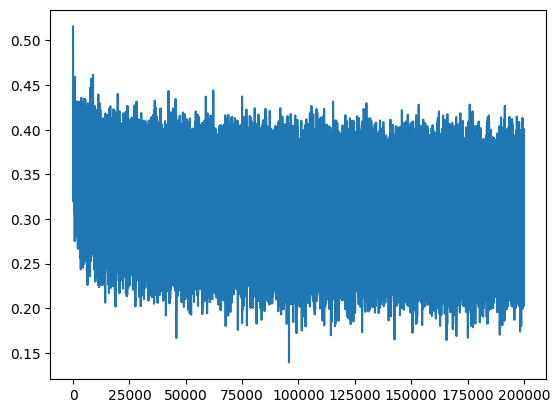

In [310]:
plt.plot(list(map(lambda x: x.log10().item(), losstrn)))

### Print the loss on the training, validation and testing datasets

In [311]:
print(f"Training Loss: {getloss(Xtrn, Ytrn).item()}")
print(f"Validation Loss: {getloss(Xdev, Ydev).item()}")
print(f"Testing Loss: {getloss(Xtst, Ytst).item()}")

Training Loss: 2.017284870147705
Validation Loss: 2.103180408477783
Testing Loss: 2.108599901199341


(array([2260.,  373.,  245.,  199.,  152.,  142.,  160.,  115.,  114.,
          82.,   85.,   61.,   76.,   47.,   60.,   68.,   76.,   57.,
          68.,   55.,   66.,   54.,   46.,   59.,   57.,   66.,   47.,
          49.,   53.,   74.,   41.,   56.,   44.,   80.,   61.,   62.,
          52.,   63.,   68.,   88.,  107.,  120.,  127.,  102.,  128.,
         150.,  193.,  264.,  391., 2337.]),
 array([-1.  , -0.96, -0.92, -0.88, -0.84, -0.8 , -0.76, -0.72, -0.68,
        -0.64, -0.6 , -0.56, -0.52, -0.48, -0.44, -0.4 , -0.36, -0.32,
        -0.28, -0.24, -0.2 , -0.16, -0.12, -0.08, -0.04,  0.  ,  0.04,
         0.08,  0.12,  0.16,  0.2 ,  0.24,  0.28,  0.32,  0.36,  0.4 ,
         0.44,  0.48,  0.52,  0.56,  0.6 ,  0.64,  0.68,  0.72,  0.76,
         0.8 ,  0.84,  0.88,  0.92,  0.96,  1.  ]),
 <BarContainer object of 50 artists>)

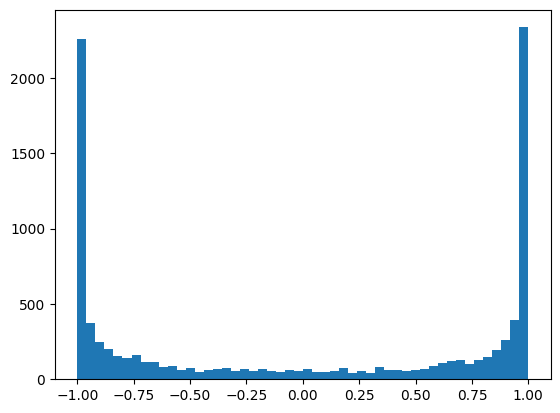

In [312]:
plt.hist(h.view(-1).tolist(), bins=50)

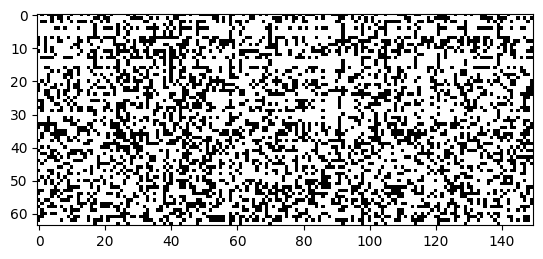

In [313]:
plt.imshow(h.abs() < 0.99, cmap='gray', interpolation='nearest')

(array([  1.,   0.,   1.,   2.,   1.,   7.,   6.,   9.,  18.,  25.,  34.,
         38.,  76.,  73., 105., 141., 155., 183., 268., 303., 366., 419.,
        446., 584., 686., 620., 610., 614., 621., 571., 500., 374., 349.,
        331., 246., 215., 142., 119.,  94.,  73.,  46.,  46.,  23.,  18.,
          9.,  10.,   9.,   4.,   5.,   4.]),
 array([-12.07770729, -11.6191757 , -11.16064411, -10.70211252,
        -10.24358093,  -9.78504934,  -9.32651775,  -8.86798616,
         -8.40945457,  -7.95092299,  -7.4923914 ,  -7.03385981,
         -6.57532822,  -6.11679663,  -5.65826504,  -5.19973345,
         -4.74120186,  -4.28267027,  -3.82413868,  -3.36560709,
         -2.9070755 ,  -2.44854391,  -1.99001232,  -1.53148073,
         -1.07294914,  -0.61441755,  -0.15588596,   0.30264563,
          0.76117722,   1.21970881,   1.67824039,   2.13677198,
          2.59530357,   3.05383516,   3.51236675,   3.97089834,
          4.42942993,   4.88796152,   5.34649311,   5.8050247 ,
          6.263556

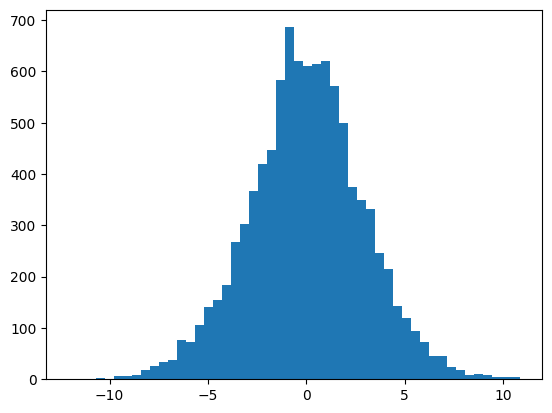

In [314]:
plt.hist((emb.view((-1, block_size*dims)) @ W1 + b1).view(-1).tolist(), bins=50)

### Function to generate a new word based using current model

In [307]:
def generate():
    op = []
    context = [0] * block_size
    while True:
        emb = C[torch.tensor([context])]
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        # print(probs)
        nxti = torch.multinomial(probs, num_samples=1).item()
        if nxti == 0: return ''.join([itoc[x] for x in op])
        context = context[1:] + [nxti]
        op.append(nxti)

### Generate and print 20 samples

In [308]:
for _ in range(20): print(generate())

fyswdjuieaqixewqxeaffrxuwrnnhozxoybpflz
tnf
phfzooredsp
rbsddqrztcgauufagvholycmfdkvjn
woqutymvshw
ejacqbmxnrougeyjjcxkwrdexpd
qgmjdujtqgpzntmijswtxaankhbrak
dicomdb
cyqxwuwylbs
rfffvgpfstytvookxdvpmh
eesfqejxqvpugqscctceizpmaghlhe
ynukjzv
fmigdwdohohzqnxmkopszxjhatbjsytazxclomjazfwtkpnvyajcmjjosetcryjvlckbadcmbmblhxcugxischxlttpgcvhipgyehibhauti
znqnqw
baujigtczhj
ohegunnzjhyhlpxckgeughanwipgjjowvuyyzthlyvim
zwfrv
hyi
xvgc
ntipniorjguymmjtsbcbblebmgyuzgzshv
